Importando as Bibliotecas

In [60]:
import numpy as np
import plotly.graph_objects as go
from scipy.special import gamma
import scipy.stats as stats
import arviz as az
import matplotlib.pyplot as plt

#### Definindo Variáveis Iniciais

In [61]:
n = 10**4 # Número de vetores thetas
k = 10**1 # Número de bins
m = 3 # Dimensionalidade
x = np.random.randint(0, 11, m) # Vetor x
y = np.random.randint(0, 11, m) # Vetor y

alfa = x + y # Vetor Alfa = Vetor x + Vetor y

#### Definindo Funções Principais

In [62]:
def f(theta, alfa, constante):
    log_produtorio = np.sum((alfa - 1) * np.log(theta), axis=1) # Para acelerar as operações, faz-se log do produtório (vira somatório)
    return np.exp(log_produtorio)/constante

def beta_multivariavel(alfa): # Beta(a + b) = Gamma(a)Gamma(b)/Gamma(a + b)
    log_produtorio = np.sum(np.log(gamma(alfa)))
    return np.exp(log_produtorio)/gamma(np.sum(alfa))

#### Gerando Amostras por meio de MCMC

In [63]:
def f_dir(x, a):
    if ((x < 0).any()): return 0.0
    t=np.empty_like(x)
    for i in range(len(x)):
        t[i]=np.power(x[i],(a[i]-1))
    return np.prod(t)

def cria_cov(alfa):
    M = [0.0]*(m - 1)
    M = [M]*(m - 1)
    M = np.array(M)

    for i in range(m - 1):
        for j in range(m - 1):

            if i == j:
                M[i, j] = alfa[i] * (sum(alfa) - alfa[i]) / \
                          ((sum(alfa) ** 2) * (sum(alfa) + 1))  # cálculo das variâncias
            else:
                M[i, j] = -alfa[i] * alfa[j] / \
                      ((sum(alfa) ** 2) * (sum(alfa) + 1))  # cálculo das covariâncias

    return M

def met_ac(pontos,p,b,alfa):
    for i in range(1,len(pontos)):
        ponto_atual = [0]*m
        for j in range(m - 1):
            ponto_atual[j] = pontos[i-1][j] + p[i,j]
        ponto_atual[-1] = 1 - np.sum(ponto_atual[:-1])
        ponto_atual = np.array(ponto_atual)
        # algoritmo de aceitação de Metropolis
        ac = min(1, f_dir(ponto_atual, alfa) /
                 f_dir(pontos[i-1], alfa))
        if ac >= b[i]:
            pontos[i] = np.array(ponto_atual)
        else:
            pontos[i] = pontos[i-1]

    return pontos

def calcular_burn_in(cadeia, alfa, limiar_densidade=0.5):
    densidades = np.array([f_dir(theta, alfa) for theta in cadeia])
    max_densidade = np.max(densidades)
    limiar_alto = limiar_densidade * max_densidade

    max_index = 0
    max_density_value = 0

    for i, densidade in enumerate(densidades[:len(cadeia) // 4]):
        if densidade >= limiar_alto:
            return i
        if densidade > max_density_value:
            max_density_value = densidade
            max_index = i
    
    return max_index

def gera_dir(alfa, n):
    
    thetas = np.array([np.array([1]*m)/m for _ in range(n)])
    M = cria_cov(alfa)
    
    p = np.random.multivariate_normal([0]*(m - 1), M,size=n)  # gera da Normal Multivariada
    b = np.random.uniform(0,1,size=n)
    dir=met_ac(thetas,p,b,alfa)

    burn_in = calcular_burn_in(dir, alfa)
    return dir[burn_in:]

thetas = gera_dir(alfa, n)
thetas

array([[0.21482338, 0.30480449, 0.48037212],
       [0.24015763, 0.37284407, 0.38699831],
       [0.27760994, 0.31410809, 0.40828197],
       ...,
       [0.21451485, 0.45395038, 0.33153478],
       [0.21451485, 0.45395038, 0.33153478],
       [0.14616282, 0.45413237, 0.39970481]])

In [64]:
def criar_lista_v(lista_f_ord, n, k):
    # Define-se os pontos de corte v
    # - v_0 = 0; v_k = sup(f(theta))
    resto = n % k
    tamanho_bin = n // k

    # No entanto, quando n%k = c != 0, precisa-se adaptar o tamanho de c bins com um ponto a mais
    ajuste = np.concatenate((np.arange(1, resto + 1), np.array([resto] * (k - resto)))) # Array para ajustar o tamanho dos bins
    lista_intermed = np.arange(1, k + 1) * tamanho_bin + ajuste
    lista_v = np.concatenate(([0], lista_f_ord[lista_intermed - 1]))
    return lista_v, lista_intermed

#### Gerando Thetas e Aplicando $f(\theta)$

In [65]:
lista_f = f(thetas, alfa, beta_multivariavel(alfa)) # Aplicar f em cada vetor theta

#### Ordenando as Listas e Criando Cortes

In [66]:
lista_f_ord = np.sort(lista_f) # Ordena a lista de resultados
sup_f = lista_f_ord[-1] # Define o supremo de f(theta) como o valor máximo obtido

lista_v, lista_intermed = criar_lista_v(lista_f_ord, len(lista_f_ord), k)

#### Analisando Visualmente a relação magnitude x $f(\theta)$

In [67]:
lista_r = [np.linalg.norm(theta) for theta in thetas] # Encontra o módulo de cada vetor theta
lista_pontos = [(lista_r[i], lista_f[i]) for i in range(len(thetas))]

a = [p[0] for p in lista_pontos]
b = [p[1] for p in lista_pontos]

# Plotando o scatter plot
fig = go.Figure()

# Scatter plot de f(theta) x Módulo Theta
fig.add_trace(go.Scatter(x=a, y=b, mode='markers', marker=dict(color='blue', symbol='circle')))

# Adicionando as linhas de cada corte v
for v in lista_v:
    fig.add_shape(type="line", x0=0, y0=v, x1=5, y1=v, line=dict(color="red", dash="dash"))

# Layout
fig.update_layout(title='Distribuição da Função segundo Magnitude do Vetor e Cortes',
                  xaxis_title='Magnitude',
                  yaxis_title='f',
                  xaxis=dict(range=[min(a), max(a)]),
                  yaxis=dict(range=[min(b), max(b)]),
                  plot_bgcolor='rgba(0,0,0,0)') # Define a cor de fundo do plot

fig.show()

#### Interpolando os Dados e Expondo Gráficos

In [68]:
from scipy.interpolate import PchipInterpolator

In [69]:
fracao = np.concatenate((np.array([0]), lista_intermed))/n # Identifica a fração total de pontos de 0 até o ponto v

interp = PchipInterpolator(lista_v, fracao)
# Utiliza um interpolador PCHIP para gerar um polinômio de terceiro grau que aproxime W(v)
# Dessa forma, obtém-se U(v)

# Define os pontos onde deseja-se avaliar a função interpolada
x_new = np.linspace(0, lista_v[-1], 100)

# Avalia a função interpolada nos novos pontos
y_new = interp(x_new)

fig = go.Figure()

# Scatter plot dos dados originais
fig.add_trace(go.Scatter(x=lista_v, y=fracao, mode='markers', marker=dict(color='blue', symbol='circle'), name='Dados Originais'))

# Linha de interpolação PCHIP
fig.add_trace(go.Scatter(x=x_new, y=y_new, mode='lines', name='Interpolação PCHIP'))

# Layout
fig.update_layout(title='Resultados da Interpolação PCHIP',
                  xaxis_title='f',
                  yaxis_title='Probabilidade Acumulada',
                  showlegend=True,
                  plot_bgcolor='rgba(0,0,0,0)') # Define a cor de fundo do plot

fig.show()

<xarray.Dataset> Size: 36B
Dimensions:  (x_dim_0: 3)
Coordinates:
  * x_dim_0  (x_dim_0) int32 12B 0 1 2
Data variables:
    x        (x_dim_0) float64 24B 1.002 1.001 1.001


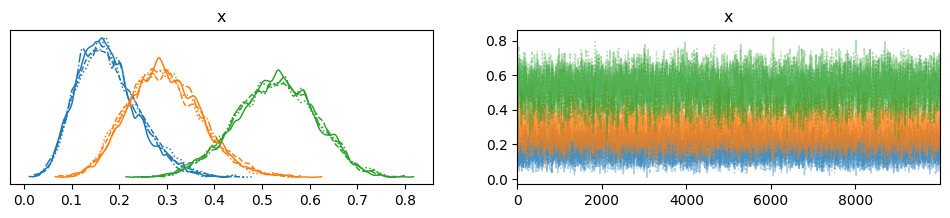

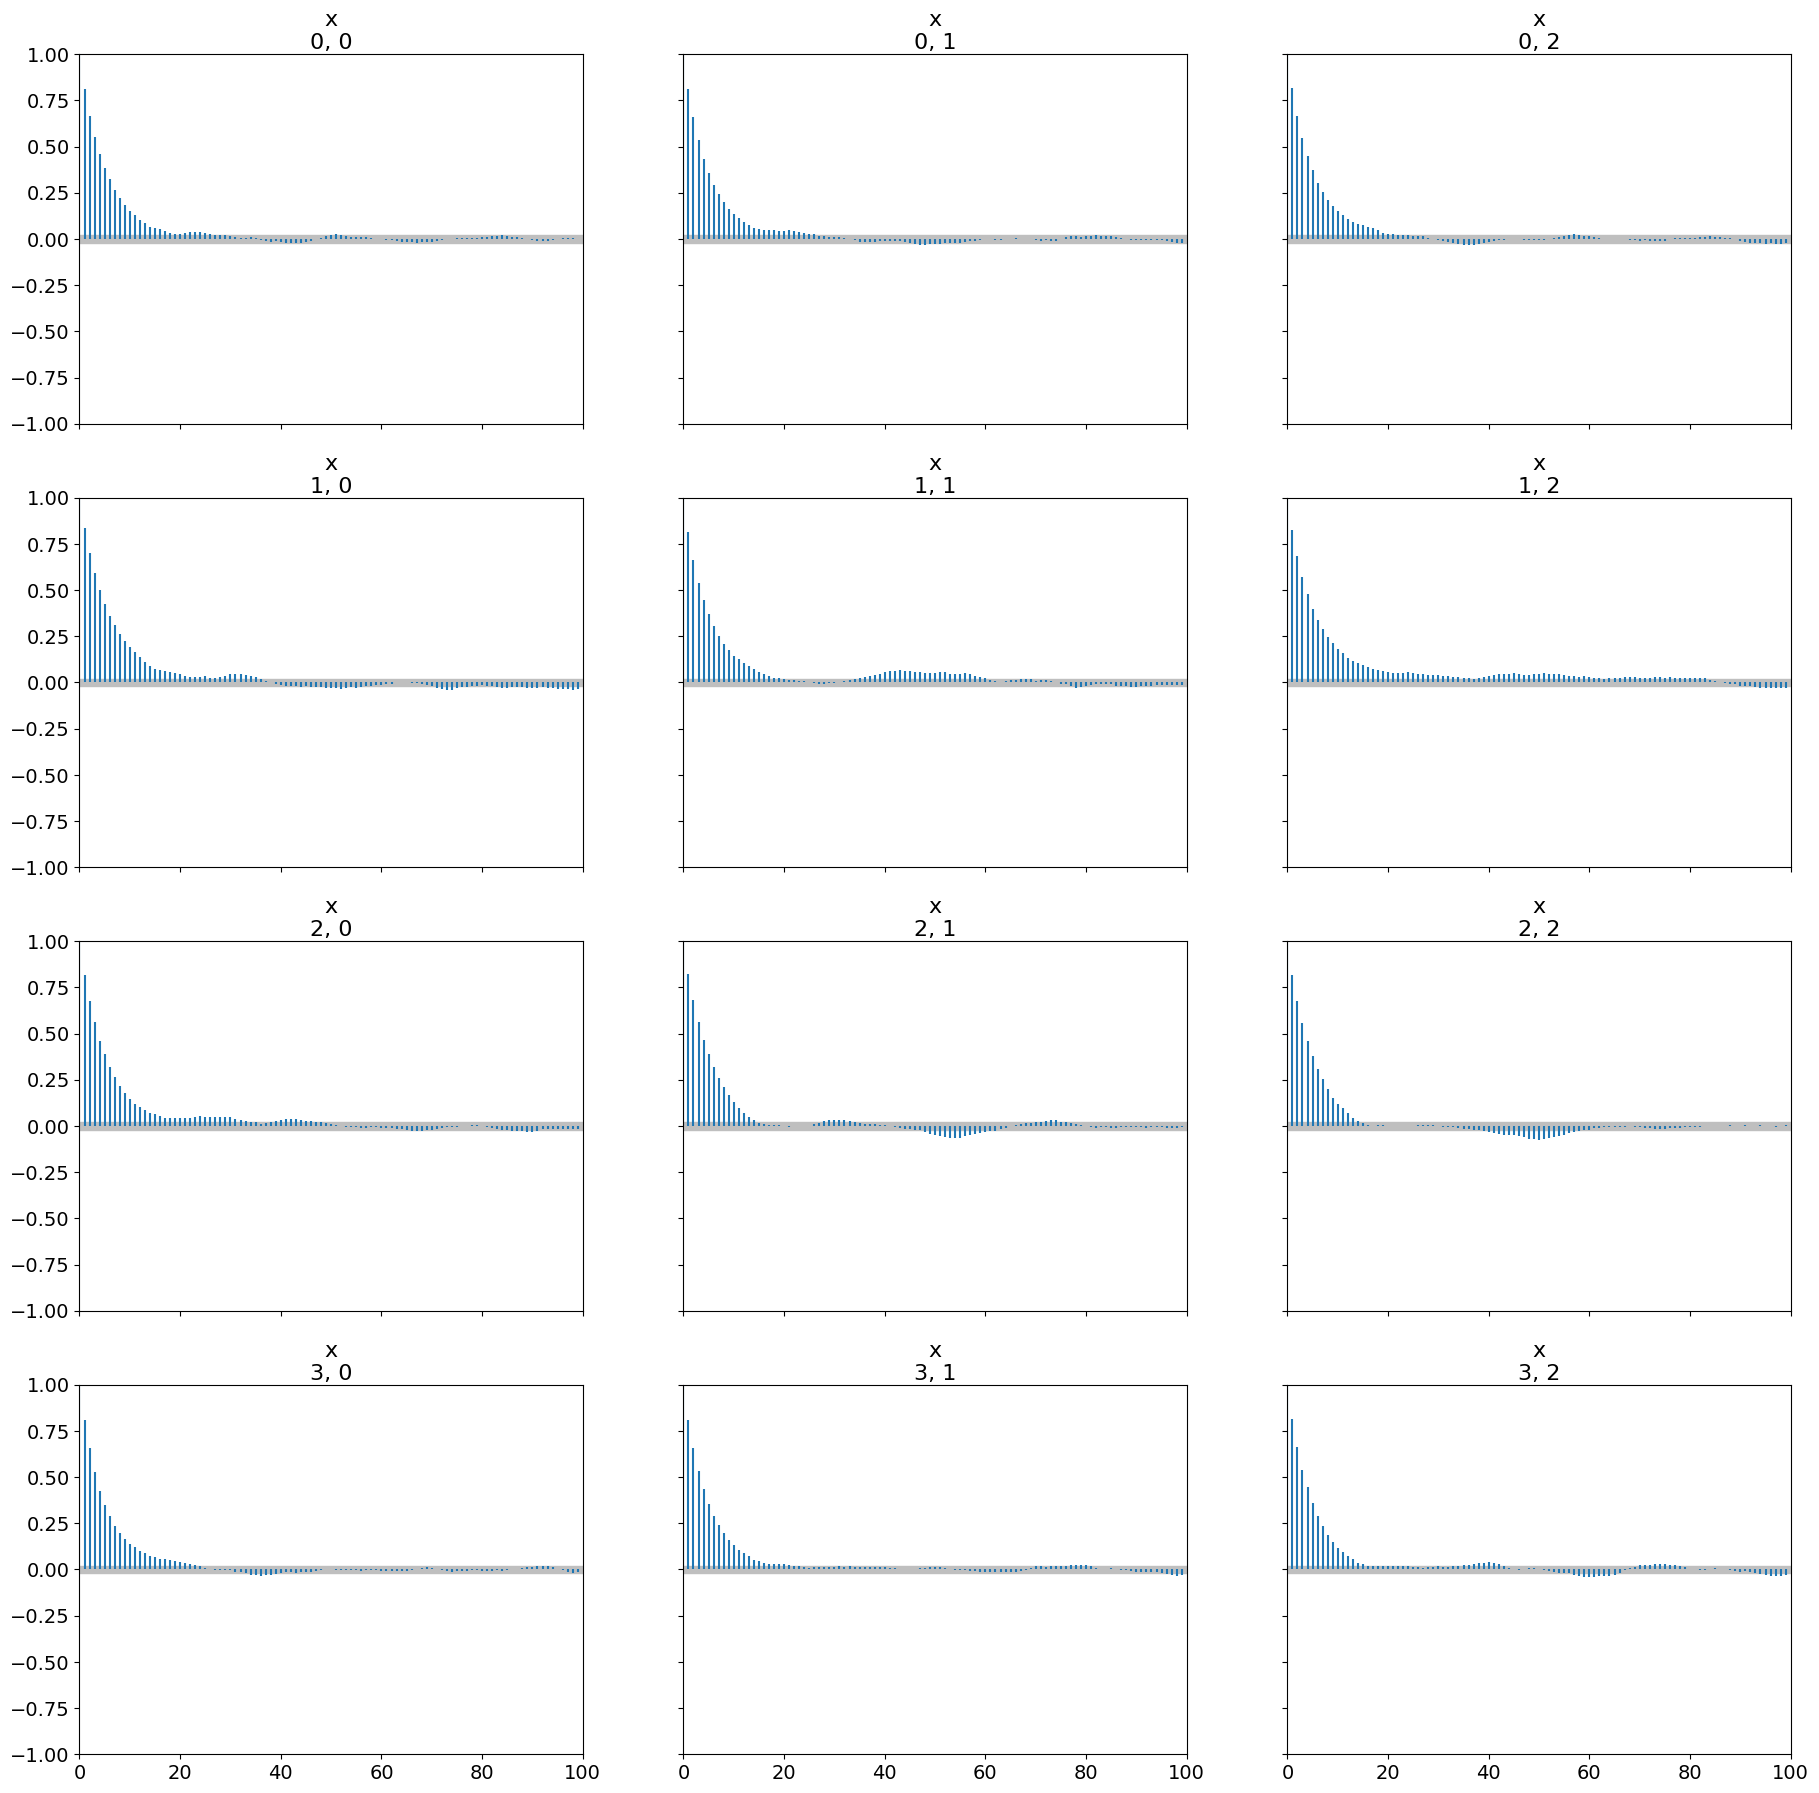

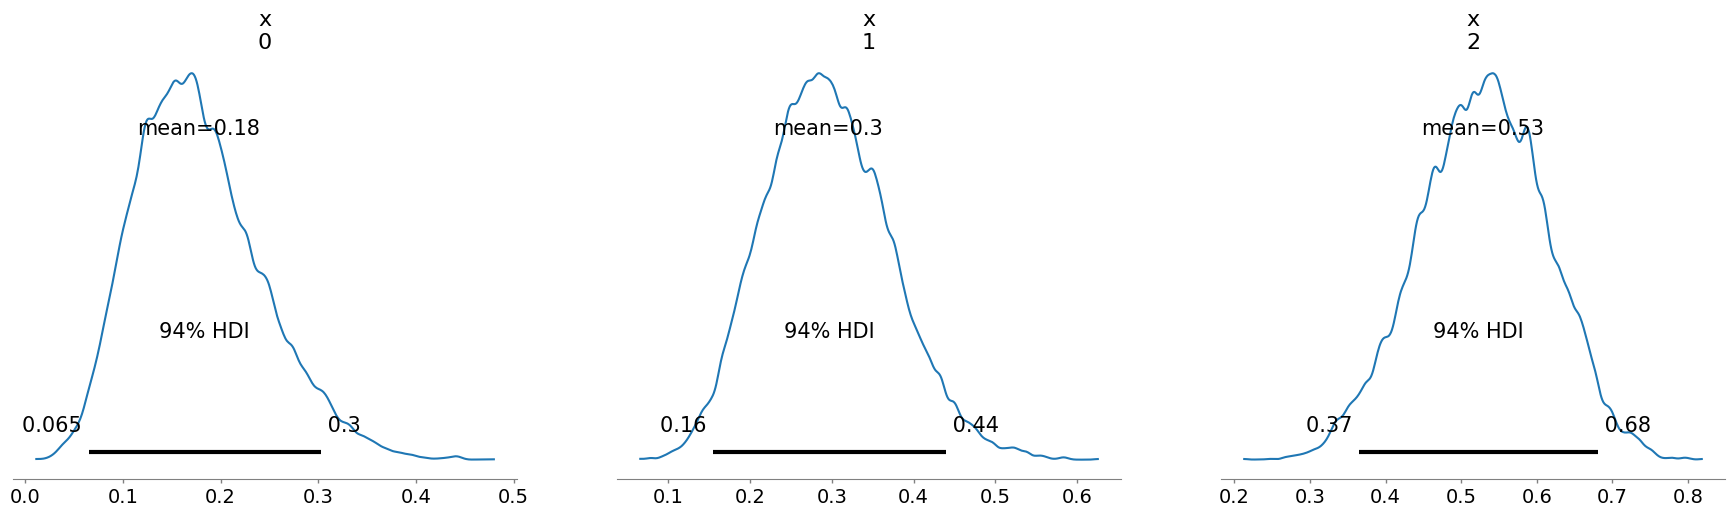

In [70]:
def gera_dir(alfa, n):
    
    thetas = np.array([np.array([1]*m)/m for _ in range(n)])
    M = cria_cov(alfa)
    
    p = np.random.multivariate_normal([0]*(m - 1), M,size=n)  # gera da Normal Multivariada
    b = np.random.uniform(0,1,size=n)
    dir=met_ac(thetas,p,b,alfa)

    return dir

def gerar_multiplas_cadeias(alfa, n, num_chains):
    cadeias = []
    for _ in range(num_chains):
        cadeia = gera_dir(alfa, n)
        cadeias.append(cadeia)

    return cadeias

# Exemplo de uso:
n = 10**4  # Número de amostras em cada cadeia
num_chains = 4  # Número de cadeias

# Gerar múltiplas cadeias
cadeias = gerar_multiplas_cadeias(alfa, n, num_chains)

# Converter para um formato adequado para ArviZ
# ArviZ espera que as cadeias estejam em um array com a forma (num_chains, num_samples, num_params)
cadeias_array = np.array(cadeias)

# Calcular R-hat usando ArviZ
trace = az.convert_to_inference_data(cadeias_array)
rhat = az.rhat(trace)
print(rhat)

# Visualizar trace plots e outras análises
az.plot_trace(trace)
plt.show()

az.plot_autocorr(trace)
plt.show()

az.plot_posterior(trace)
plt.show()